# Practicals 2 - Pytorch: Training and Evaluating a simple CNN

In [ ]:
# common imports
import numpy as np
import os
import random

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Path variables
PROJECT_ROOT_DIR = "."
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
logging_dir = os.path.join(PROJECT_ROOT_DIR, "my_logs_2")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)


In [ ]:
# torch imports
import torch, torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim


%load_ext tensorboard

To make this notebook's output stable across runs and pytorch is deterministic; 
Since we use it over and over again, we write a function. 

In [ ]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_seed(42)

In [ ]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Define the device, if available:

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In this tutorial, we cover the CIFAR10 Dataset, which consists of 60.000 32x32 colour images in 10 classes (range 0-9), with 6.000 images per class. The task is to classify the content of each image. 

First, import the CIFAR10 Dataset from `torchvision.datasets`, [documentation](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html) 

These data are 32x32 RGB images, not yet pytorch tensors. Also, the pixel values are not normalized. We can transform the images into pytorch tensors, by using `transform= transforms.ToTensor()`. However, we don't know mean and standard deviation. Since we don't know these, let's import CIRFAR10 first and look at the data, compute mean and standard deviation, and then import the data again with a better transform which also normalizes the data. 


Now we define the train_dataset as the CIFAR10 dataset with `train=True` and the test_set with `train=False`. Download all data via `download=True` to `DATA_PATH`. We first download it without making changes (via transforms, see later). 

In [ ]:
#import CIFAR10 and load train and test data with the above transform; call the test set test_set
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root=DATA_PATH, train=True, download=True)
test_set = CIFAR10(root=DATA_PATH, train=False, download=True)

- You can access the input data of `train_dataset` via `train_dataset.data`, which is a numpy array.
- Get the shape of this array, and use this to answer the following question:
  
**Question:** what do the dimensions 0,1,2,3 stand for?

#TODO: 
0 = instances

1, 2 = height, width

3 = channel RGB

We want to load these data in a different way to train our models: we want a `transform` to 
- load the data as pytorch tensors via [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor). Note: this transform converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] by dividing by 255. 
- for each channel, normalize the pixel values of all images by the mean and standard deviation of the **training set** (even those of the validation and test set!!!). However, if we do that after turning the numpy arrays to tensors, we first need to know the mean and standard deviation of the training images **divided by 255**

Compute the mean of the above data /255  for each channel  using torch's `.mean(axis=(???))`, where you should fill out the ???. For this, note that if axis = (0,1), the output will be the mean over all entries in dimensions 0 and 1. 

Likewise, compute the standard deviation of these data 0 for each channel using torch's `.std(axis=(???))` in the same way. 

Print both balues. They should be somewhere between 0 and 1. 

In [ ]:
DATA_MEANS = (train_dataset.data/255).mean(axis=(0,1,2))
DATA_STD = (train_dataset.data/255).std(axis=(0,1,2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

We will use this information to define a tranform which normalizes the data automatically while loading using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) module which will normalize our data to zero mean and unit variance. To do this, use the above means and standard deviations as arguments of Normalize. 

First, define a `test_transform` via [`transforms.Compose`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) which first turns the data into tensors and then normalizes the data. 

In [ ]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

For the training data, we will additionally use data augmentation, see [Image Transformations](https://pytorch.org/vision/stable/transforms.html).

The idea of data augmentation (especially for images) is the following: The more data you have for training, the better. The more diverse these data are, the better. In particular you want your network to learn to identify an image as its content even if it is shifted, cropped, rotated, flipped, resized... 
Therefore, you randomply apply these transformations to the training images when loading them with DataLoader during each epoch, i.e. for each epoch, the training set will be different. This reduces the risk of overfitting and helps CNNs to generalize better. 

Here, we will apply two random augmentations:

- First, we will flip each image horizontally by a chance of 50% (`transforms.RandomHorizontalFlip`). The object class usually does not change when flipping an image, and we don't expect any image information to be dependent on the horizontal orientation. This would be however different if we would try to detect digits or letters in an image, as those have a certain orientation.

- The second augmentation we use is called `transforms.RandomResizedCrop`. This transformation scales the image in a small range, while eventually changing the aspect ratio, and crops it afterward in the previous size. Therefore, the actual pixel values change while the content or overall semantics of the image stays the same. 



So in the next cell, use `transforms.Compose` to define a transformation pipeline called `train_transform` with the following steps in order: 
- random horizontal flip
- random resized crop with `scale=(0.8,1.0),ratio=(0.9,1.1)`
- transform to tensor
- normalize like before

**Question:** Which of the above augmentaion methods would you NOT use for the MNIST data?

**Answer:** #TODO

horizontal flip, because it changes the numbers
random crops, because numbers might not be legible any more. 

In [ ]:
# For training, we add some augmentation do decrease the risk of overfitting.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])

Use these transforms to load the `train_dataset` again with the `train_transform`, and the `test_set` with the `test_transform`. 

Next we want to split the training dataset into a training and a validation set with `torch.utils.data.random_split`. However, there is a little problem: since we want to use the validation data like the test data, i.e. without augmentation, we should not use the 'train_transform' on these data, but the `test_transform`! But: we need the data to be from the training-set. 

**Question:** How can we solve this dilemma? Try to think of a way yourself. 
Hint: Can you only load the `train_dataset` once? But: you need the same random seeds!

#TODO

Load the train dataset twice, and split it twice with the same random seed, once with the `train_transforms`, once with `test_transforms`. Keep the `train_set` from the first, and the `val_set` from the latter. 

In [ ]:
# Loading the test set
test_set = CIFAR10(root=DATA_PATH, train=False, transform=test_transform)

# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATA_PATH, train=True, transform=train_transform)
val_dataset = CIFAR10(root=DATA_PATH, train=True, transform=test_transform)
set_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
set_seed(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

Next, use [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to create three iterables called `train_loader`, `val_loader`, `test_loader`over the test, train and validation sets that divide the data into batches of size 128.

Important: While we need the train_set to be loaded with `shuffle=True` because we want different random orders for each training epoch, we don't need to shuffle val_set and test_set

In [ ]:
# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=32, shuffle=False, drop_last=False)

In [ ]:
# Don't be confused: 
print((train_dataset.data).mean(axis=(0,1,2)))
print((train_dataset.data).std(axis=(0,1,2)))

# Transforms only works via the Dataloader: 
imgs, _ = next(iter(train_loader))
print("Batch mean", imgs.mean(dim=[0,1,2]))
print("Batch std", imgs.std(dim=[0,1,2]))

Let's draw some of the training data

In [ ]:
# Let's draw some of the training data
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], interpolation='none',cmap='gray')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
  print(example_data[i][0])
plt.show()



## Quick Repetition of Convolution Neural Networks (CNNs)



We saw in last semester's MNIST practicals that "classical" ML methods don't work well on images. 
Reasons: 
- cropping an image or resizing it changes the pixel values a lot, but it doen't change the content of the image
- even "small" images have many pixels $\Rightarrow$ high input dimensionality 

Convolution Neural Networks deal with these issues using filters/kernels. 

**Question:** Quickly describe
- what an individual filter looks like for C input channels of dimension HxB 
- how filters/kernels are used for feature detection in a ConvLayer
- What is the output tensor dimension for input size CxHxB and D filters, filter size 5x5, stride 1, no padding?


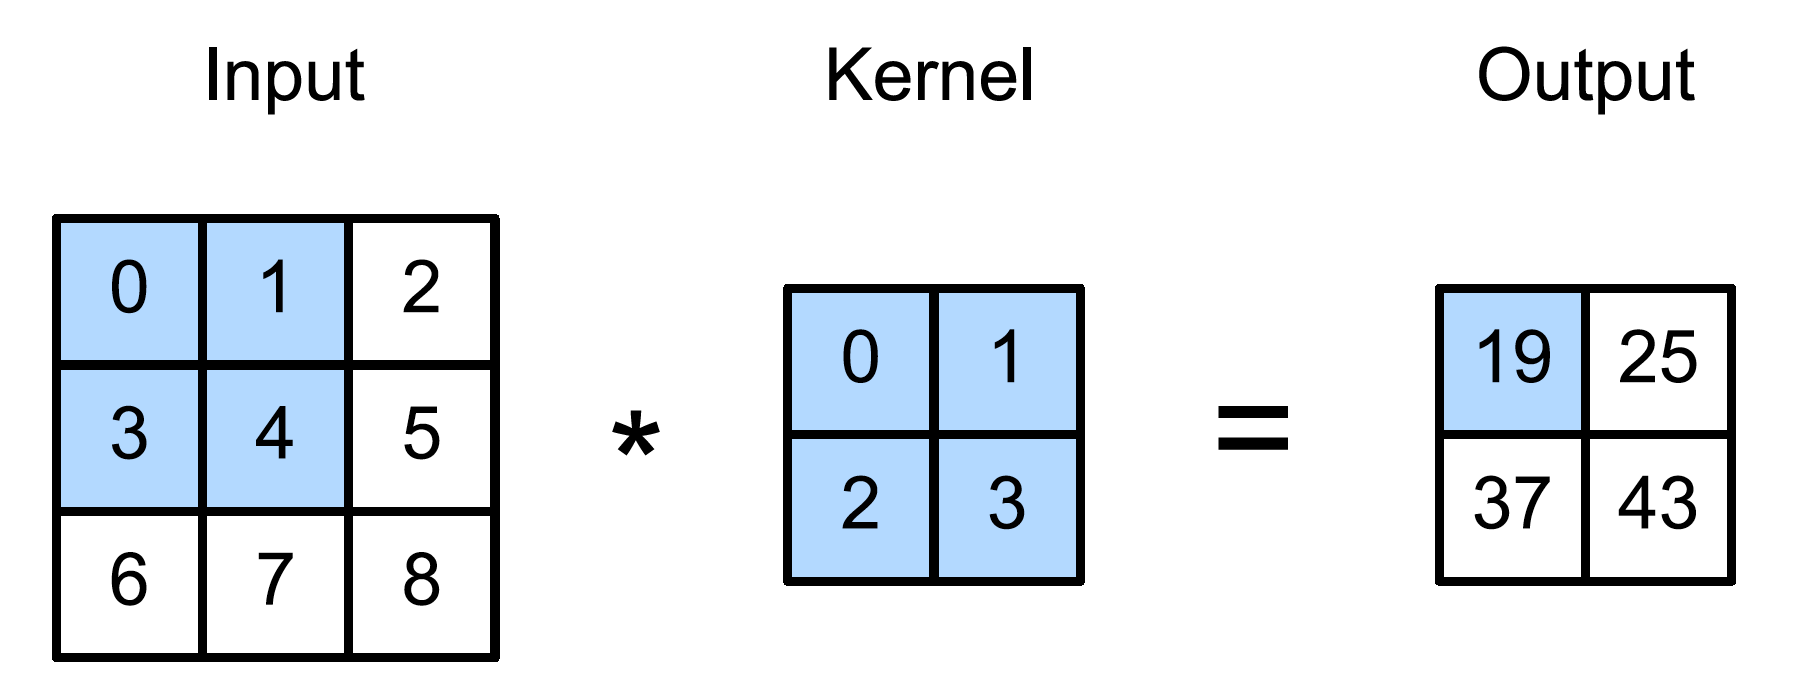

Docu: [Convolution Layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)



#TODO 

Quickly describe
- a tensor of size C x kernel_size x kernel_size
- see lecture
- Dx(H-4)x(B-4)

**Question:** What makes sure of translation invariance in CNNs?

**Answer:** #TODO 

- Convolution Layers for global feature detection: Sliding the same filters over the entire image matrices to detect features regardless of their position
- Pooling Layers for local translation invariance: forget the original position of things inside the kernel window


**Question:** What helps reducing the number of parameters in CNNs?

**Answer:** #TODO 

Filters only have input-channels x output-channels x kernel_size^2 many parameters, not input-channels x output-channels x H x B many. 

Create the following NN class as a `nn.Module`-Subclass:

- a first [Convolution Layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with 8 out-channels, kernel_size 3, and the rest default values `nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size)`
- ReLU
- a [dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html?highlight=dropout2d#torch.nn.Dropout2d) for the convolution layer. Since we are dealing with 2d-instances here, you need `nn.Dropout2d()`.
- [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) with default values 
- [max_pool](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) filter size 2x2, padding 1, rest default values
- a second [Convolution Layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with 16 out-channels,  kernel_size 3, SAME convolution (which padding dimension do you need?) and the rest default values `nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size)`
- ReLu
- a dropout layer for the convolution. again: `nn.Dropout2d()`. 
- [Batch Normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) with default values
- [max_pool](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) 2x2
- a third [Convolution Layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with 32 out-channels, kernel_size 5,and the rest default values `nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size)`
- ReLu
- dropout
- [global average pool](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.functional.avg_pool2d.html#torch.ao.nn.quantized.functional.avg_pool2d)= avg_pool mit kernel-size = image-size
- [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#flatten) 
- [Fully Connected/Linear Layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear): determine the input and output size you need yourself! `nn.Linear(in_dimension, out_dimension)`
You will find out that you need to know the input dimension of the last Fully Connected Layer = output dimension of the Flatten Layer. 
- Note: do NOT use the softmax as a last layer here. The softmax is included in the loss function we use later!


**Question:** 
- Determine the in- and output dimensions of all Layers as well as number of learnable parameters (weights and biases) for input size 3x32x32 by filling in the table below.What output dimension do you need? 
- What would be the number of parameters for the Normalization Layers if we used [Layer Normalization](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) with (elementwise_affine=True, bias = True)? However, Batch Normalization works better with CNNs. 
- Explain the difference between Batch Normalization and Layer Normalization by stating which sets of values are normalized over.

#TODO

input size: 3x32x32

|Layer|output dimension |weights|bias|
|:---|:---|:---|:---|
|1st Conv| 8x30x30|3x3x3x8|8|
|dropout|8x30x30|0|0|
|batchnorm|8x30x30|8|8|
|max_pool|8x16x16|0|0|
|2nd Conv|16x16x16|8x3x3x16|16|
|dropout|16x16x16|0|0|
|batchnorm|16x16x16|16|16|
|max_pool|16x8x8|0|0|
|3rd Conv|32x4x4|16x5x5x32|32|
|dropout|32x4x4|0|0|
|global avg_pool|32x1x1|0|0|
|flatten|32|0|0|
|linear|10|320|10|

If we used Layer Normalization, we would learn gamma and beta for each input neuron, i.e. CxHxB-many. In this case for the first layer, we would have 8x30x30 parameters, and for the second 16x16x16.

Layer Normalization: Normalize over all neurons in one layer, i.e. CxHxB many neurons, for each input. 
Batch Normalization: Normalize over all instances in one batch and all spatial dimensions, i.e. N(=Batch size)xHxB many neurons.


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Valid convolution, 3 channels in, 8 channels out, stride 1, kernel size = 3
        self.conv1 = nn.Conv2d(3, 8, 3)
        # Dropout for convolutions
        self.drop = nn.Dropout2d(p=0.5)
        # Batch normalization with learnable gamma and beta for each channel 
        self.norm1 = torch.nn.BatchNorm2d(8)
        self.norm2 = torch.nn.BatchNorm2d(16)
        # Valid convolution, 8 channels in, 16 channels out, stride 1, kernel size = 3
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        # Valid convolution, 8 channels in, 3 channels out, stride 1, kernel size = 35
        self.conv3 = nn.Conv2d(16, 32, 5)
        # MaxPool2d with padding 1
        self.maxpool1 = nn.MaxPool2d(2,2, padding=1)
        # MaxPool2d with padding 0
        self.maxpool2 = nn.MaxPool2d(2,2)
        # Global Average Pooling
        self.avg_pool = nn.AvgPool2d(4)
        # Flatten
        self.flatten = nn.Flatten()
        # Fully connected layer
        self.fc1 = nn.Linear(32,10)
        #self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #x = self.drop(x)
        x = self.norm1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        #x = self.drop(x)
        x = self.norm2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        #x = self.drop(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        return x

Create a NN from this class called model and push it to the device. 

In [ ]:
model = ConvNet()
model.to(device)

In [ ]:
from torchinfo import summary

summary(model, input_size=(128, 3, 32, 32))

You can access the model's layers via the following code: 

In [ ]:
layers = list(model.children())
print(layers)

### Model Initialization 

Next, we initialize the NN appropriately. 
**Question:** Since we have a ReLU in the network, how would we initialize those layers?


#TODO

He Initialization. 

print out the names for all `name, param in model.named_parameters()`

In [ ]:
for name, param in model.named_parameters(): 
    print(name)

Write a function he_init which takes `model` as an input and initializes the parameters (`name, param in model.named_parameters()` gives each layer's bias and weight parameters) as it should: 

- initialize bias vectors (use `name.endswith') as 0
- initialize weight vectors for the linear layer (use `name.startswith`) using LeCun initialization using [.normal()](https://pytorch.org/docs/stable/generated/torch.normal.html) on `param.data` (note that you get the number of incoming arrows = rows of weight matrix using `param.shape[1]`)
-  initialize weight vectors for all Conv layers with He/Kaiming
-  initialize normalization layers with samples from the uniform normal distribution (mean 0, std 1)

In [ ]:
import math

def he_init(model):
    for name, param in model.named_parameters():
        if name.endswith("bias"):
            param.data.fill_(0)
        elif name.startswith("fc"): 
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        elif name.startswith("norm"): 
            param.data.fill_(1)
        elif name.startswith("conv"):
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))
        else: param.data.normal_(0, 1)


In [ ]:
# Alternative
def he_init_2(model):
    for name, param in model.named_parameters():
        if name.endswith("bias"):
            param.data.fill_(0)
        elif name.startswith("fc"): 
            torch.nn.init.normal_(param, std=1/math.sqrt(param.shape[1]))
        elif name.startswith("norm"): 
            torch.nn.init.ones_(param)
        elif name.startswith("conv"):
            torch.nn.init.kaiming_normal_(param)
        else: torch.nn.init.normal_(param)

Actually, this is not strictly necessary - all layers have a default initializating by Pytorch! 

Now define three DataLoaders `train_loader`, `val_loader`, and `test_loader`. 

Initialize `model`

In [ ]:
he_init_2(model)

### Training the Model

Training works in several steps: 
- Define an optimizer
- Define a loss
- Write a training function using optimizer and loss
- Do the training

First, define the optimizer als `optim.Adam` with `lr=0.01` in the following cell:

In [ ]:
print([param.data for name, param in model.named_parameters()])

In [ ]:
pred = model(example_data)
pred_label = pred.argmax(dim=-1)
print(pred)
print(pred.argmax(dim=-1))

In [ ]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

Define a "loss_module" as `nn.CrossEntropyLoss`. Why did we not need a Softmax  in the classification layer?

#TODO

CrossEntropyLoss includes the Softmax

In [ ]:
loss_module = nn.CrossEntropyLoss()

Next, as an exercise to really understand how training works, let's write a simple training function `train(epochs)` (please don't look at the lecture notes on PyTorch for this task!) that performs training for `epochs` many epochs only: 
- put model in train mode
- go through epochs
- go through indexed batches `batch_idx, (data, labels)` of `enumerate(train_loader)` and do the following: 
    - push data and targets to the device
    - for each epoch
    - forward pass: calculate the output of the model on the data
    - compute the loss by applying `loss_module` to target and output
    - set the gradient to 0 with `zero_grad()` applied to the optimizer
    - compute the gradient with backpropagation by applying `.backward()` to the loss calculated above
    - take one optimization step in direction of the negative gradient by applying `.step()` to `optimizer`.
    - after each epoch, produce an output of the form: `print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(epoch, loss.item()))`

In [ ]:
def train(epochs):
  model.train()
  # Get each batch, take an optimization step

  # cycle through epochs
  for epoch in range(epochs): 
    epoch_loss = 0.0
    for data, labels in train_loader:
      data = data.to(device)
      labels = labels.to(device)
      output = model(data)
      output = output.squeeze(dim=1)
      loss = loss_module(output, labels)
      loss.backward()
      optimizer.zero_grad()
      optimizer.step()
      epoch_loss =+ loss.item()
      
      # Output
    print('Train Epoch: {} \tLoss: {:.6f}'.format(
        epoch, epoch_loss))


Train the model with this function for 5 epochs.

In [ ]:
train(5)

Since we want to use TensorBoard, however, we don't use the above function, but the `train_model_with_logger` from the lecture. 
Copy the function and try to really understand what happens in each line. Modify it to 
- additionally compute the epoch's accuracy epoch_acc like in the eval_mode function in the lecture
- add this accuracy to the TensorBoard Scalars
- output the epoch_loss and epoch_acc after each epoch.

In [ ]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

def train_model_with_logger(model, optimizer, data_loader, loss_module, num_epochs, logging_dir='runs/our_experiment'):

    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False

    # Training loop
    for epoch in range(num_epochs):

        # Set model to train mode
        model.train()
         
        epoch_loss = 0.0
        true_preds, num_preds = 0.0, 0.0

        for inputs, labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, inputs)
                model_plotted = True

            ## Step 2: Run the model on the input data
            preds = model(inputs)
            print(preds)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 2.5: Compute the predicted label
            preds_labels = preds.argmax(dim=-1) 

            ## Step 3: Calculate the training loss 
            loss = loss_module(preds, labels)
            
            ## Step 4: Perform backpropagation

            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()

            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            ## Step 6: Take the running average of loss and update true
            epoch_loss += loss.item()
            ## Step 6.5: update number of correct predictions und number of predictions
            true_preds += (preds_labels==labels).sum().item()
            num_preds += labels.shape[0]

        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)
        
        # Add training accuracy to TensorBoard
        epoch_acc = true_preds/num_preds
        writer.add_scalar('training_accuracy',
                          epoch_acc,
                          global_step = epoch + 1)

        
        # Produce the output
        print(f'''Epoch: {epoch} Training loss: {epoch_loss:.2f} Training accuracy: {epoch_acc:.2f}''')

    writer.close()

Now, train the model for 10-50 epochs using the train_model_with_logger function, where you use the `logging_dir` defined at the top

In [ ]:
train_model_with_logger(model, optimizer, train_loader, val_loader, loss_module, num_epochs=10, logging_dir=logging_dir)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs_2 --port=6006

Next we want to take training one step further: Remember that we also have validation data! Like with Keras, we would like to get validation loss and validation metric to be output after each epoch during training and written to a logfile for TensorBoard. However, to evaluate the validation data, we first need a function to evaluate data, i.e. an `eval_model` function!

This function is different from the train function: 
- we need to set the model to `eval` mode, because some layers work differently for testing than they do for training (e.g. BatchNormalization), so the forward pass may be different
- also, obviously, we do not need to train, so we don't need to calculate gradients
- instead, we want to calculate and output performance measures

In the following cell, write a `eval_model` function similar to the one in the Pytorch Lecture, only with an additional argument `loss_module` with slight modifications, where you 
- set the model to eval mode first
- set epoch_loss, true_preds and num_preds to 0
- use `with torch.no_grad()` to make sure gradients are not computed (they are not necessary for evaluating!)
- cycle through the batches in the data_loader: 
    - push data to the device
    - do the forward pass and squeeze them
    - compute the prediction label (as the argmax `preds.argmax(dim=-1) `)
    - keep record of correct predictions and number of predictions for accuracy
    - compute this batch's loss form the loss_module and add it to the total loss
- compute loss and accuracy and print them
- return loss and accuracy in a list so you can use them later on

In [ ]:
def eval_model(model, data_loader, loss_module):
    model.eval() # Set model to eval mode
    loss = 0.0
    loss2 = 0.0
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for inputs, labels in data_loader:

            # Determine prediction of model on dev set
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs)
            #preds = preds.squeeze(dim=1)
            pred_labels = preds.argmax(dim=-1) 

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == labels).sum()
            num_preds += labels.shape[0]

            # Compute the batch's loss
            loss += loss_module(preds, labels).item()
            

    acc = true_preds / len(data_loader.dataset)
    loss = loss / len(data_loader)

    return [loss, acc]

Try out if it works by using `eval_model` on the test_loader and print loss and accuracy.

In [ ]:
loss, acc = eval_model(model, test_loader, loss_module)
print(f"Loss: {loss:.2f} Accuracy: {100.0*acc:4.2f}%")

Now we use this `eval_model` function to modify our `train_model_with_logger` to also log and output validation data after each epoch. 

Copy-paste the above `train_model_with_logger` function and call the new function `train_and_val_model_with_logger`. Modify it to  
- take `val_loader` as an additional argument 
- define an additional empty list called `val_scores` before you start cycling through the epochs to keep track of all epoch's validation scores
- for each epoch, after training, apply `eval_model` to the `val_loader` and call the returned values `val_acc` and `val_loss`. 
- Add `val_acc` to `val_scores`
- Add `val_acc` and `val_loss` as scalars to the `SummaryWriter`
- Add them in each epoch's print-out
- note: you need to shift 'model.train()' into the epochs because it is set to eval-mode during evaluation

In [ ]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

def train_model_with_logger_and_eval(model, optimizer, data_loader, val_loader, loss_module, num_epochs=100, logging_dir='runs/our_experiment'):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False

    val_scores = []
    # Training loop
    for epoch in range(num_epochs):

        # Set model to train mode: this has to be done inside the epoch because the model is set to eval-mode after each epoch during validation
        model.train()

        epoch_loss = 0.0
        true_preds, num_preds = 0.0, 0.0
        for inputs, labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, inputs)
                model_plotted = True

            ## Step 2: Run the model on the input data
            preds = model(inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 2.5: Compute the predicted label
            preds_labels = preds.argmax(dim=-1) 

            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()

            ## Step 3: Calculate the loss 
            loss = loss_module(preds, labels)
            
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            ## Step 6: Take the running average of loss and update true
            epoch_loss += loss.item()
            ## Step 6.5: update number of correct predictions und number of predictions
            true_preds += (preds_labels==labels).sum()
            num_preds += labels.shape[0]
        
        # Validation at the end of training: 
        [val_loss, val_acc] = eval_model(model, val_loader, loss_module)
        val_scores.append(val_acc)

        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)
        
        # Add training accuracy to TensorBoard
        epoch_acc = true_preds/num_preds
        writer.add_scalar('training_accuracy',
                          epoch_acc,
                          global_step = epoch + 1)
        
        # Add validation loss to TensorBoard
        writer.add_scalar('validation_loss',
                          val_loss,
                          global_step = epoch + 1)
        
        # Add validation accuracy to TensorBoard
        writer.add_scalar('validation_accuracy',
                          val_acc,
                          global_step = epoch + 1)

        # Produce the output
        print(f'''Epoch: {epoch} Training loss: {epoch_loss:.2f} Training accuracy: {epoch_acc:.2f} Validation loss: {val_loss:.2f} Validation accuracy: {val_acc:.2f}''')

    writer.close()

Finally, train the model for 50 epochs with the above function.

In [ ]:
train_model_with_logger_and_eval(model, optimizer, train_loader, val_loader, loss_module, num_epochs=50, logging_dir='runs/our_experiment')


And test it on the test data with `eval_model`. 

In [ ]:
eval_model(model, test_loader, loss_module)

In [ ]:
%tensorboard --logdir=./my_logs_2 --port=6006

## Visualizing the activations in the model

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU?
To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network. 
Call the function "visualize_activations"

In [ ]:
def visualize_activations(net, color="C0"):
    activations = {}
    
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(list(net.children())[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy() # flattens the image activations
    
    ## Plotting
    columns = 3
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*3.3, rows*3.3))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title("Layer %i - %s" % (key, list(net.children())[key].__class__.__name__))
        fig_index += 1
    #fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close() 

In [ ]:
visualize_activations(model)

## Theoretical Question

Consider a convolutional neural network block whose input size is 32 x 32 x 8. The block consists of the following layers:

-  a convolutional layer with 32 filters of size 3 x 3, 1 padding, dilation 2, with weights and bias,  + ReLU (CONV2D-1)
-  A 2 x 2 max-pooling layer with stride 2 and 0 padding (MAXPOOL)
-  A batch normalization layer (BATCHNORM)
-  A convolutional layer with 64 filters of size 3 x 3, 1 padding, stride 2, with weights and bias, + ReLU (CONV2D-2)
-  A Global Average Pooling Layer (AVGPOOL)
-  A Fully Connected Layer (FC) with 20 output units. 

All arguments that are not mentioned are default.
Fill out the following table with the number ouf output dimensions (for 3D-tensors in the format HxWxC, where H,W,C are the height, width, and channel dimensions, respectively), and number of learnable parameters for each layer. 

| Layer | Output dimension | Weights + Biases|
|---|---|---|
|CONV2D-1|30x30x32|8x3x3x32 + 32|
|MAXPOOL|15x15x32|0|
|BATCHNORM|15x15x32|32+32|
|CONV2D-2|8x8x64|32x3x3x64 + 64|
|AVGPOOL|64|0|
|FC|20|64x20 + 20|


